[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quirogaez/capstone/blob/main/notebooks/01_EDA.ipynb)

# **01_EDA – Análisis Exploratorio de Datos**

## **Importación y cargue de imágenes**

In [32]:
# Importar librerías
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Llamar los archivos**

In [3]:
img_vali = '/content/drive/MyDrive/Capstone/data/val'
img_train = '/content/drive/MyDrive/Capstone/data/train'
img_test = '/content/drive/MyDrive/Capstone/data/test'

# Ver archivos en la carpeta
df_vali = os.listdir(img_vali)
df_train = os.listdir(img_train)
df_test = os.listdir(img_test)

## **Revisión de calidad y exploración de imágenes**

**Función para evaluar la cantidad de imágenes por conjunto, tamaños y escala de color**

In [4]:
def revisar_calidad_imagenes(ruta_base):
    errores = []
    tamanos = []
    formatos = []

    # Recorrer todas las subcarpetas (NORMAL y PNEUMONIA)
    for subcarpeta in os.listdir(ruta_base):
        ruta_subcarpeta = os.path.join(ruta_base, subcarpeta)
        if os.path.isdir(ruta_subcarpeta):
            for archivo in os.listdir(ruta_subcarpeta):
                ruta_imagen = os.path.join(ruta_subcarpeta, archivo)
                try:
                    with Image.open(ruta_imagen) as img:
                        tamanos.append(img.size)     # (ancho, alto)
                        formatos.append(img.mode)    # RGB = a color, L = en escala de grises, etc.
                except Exception as e:
                    errores.append((ruta_imagen, str(e)))

    print(f"Total de imágenes revisadas: {len(tamanos) + len(errores)}")
    print(f"Imágenes con error: {len(errores)}")
    if errores:
        for ruta, error in errores:
            print(f"{ruta}: {error}")

    return tamanos, formatos

In [5]:
# Aplicar función 'revisar_calidad_imagenes' al conjunto de validación
tm_vl, for_vl = revisar_calidad_imagenes(img_vali);
print(tm_vl[:10], "\n", for_vl[:10])

Total de imágenes revisadas: 16
Imágenes con error: 0
[(1664, 1128), (1416, 944), (1192, 952), (1072, 712), (1256, 864), (968, 592), (1152, 664), (1016, 656), (1272, 1040), (1288, 928)] 
 ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [6]:
# Aplicar función 'revisar_calidad_imagenes' al conjunto de testeo
tm_ts, for_ts = revisar_calidad_imagenes(img_test)
print(tm_ts[:10], "\n", for_ts[:10])

Total de imágenes revisadas: 624
Imágenes con error: 0
[(1056, 616), (912, 648), (1120, 808), (848, 632), (952, 680), (1190, 925), (1144, 784), (1106, 762), (1120, 592), (1288, 920)] 
 ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [7]:
# Aplicar función 'revisar_calidad_imagenes' al conjunto de entrenamiento
tm_tr, for_tr = revisar_calidad_imagenes(img_train)
print(tm_tr[:10], "\n", for_tr[:10])

Total de imágenes revisadas: 5144
Imágenes con error: 0
[(1750, 1334), (1840, 1499), (1638, 1236), (2338, 1970), (1634, 1372), (1912, 1739), (2090, 1785), (1666, 1537), (1226, 955), (1808, 1488)] 
 ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


**Visualizar tamaños de imágenes por conjunto**

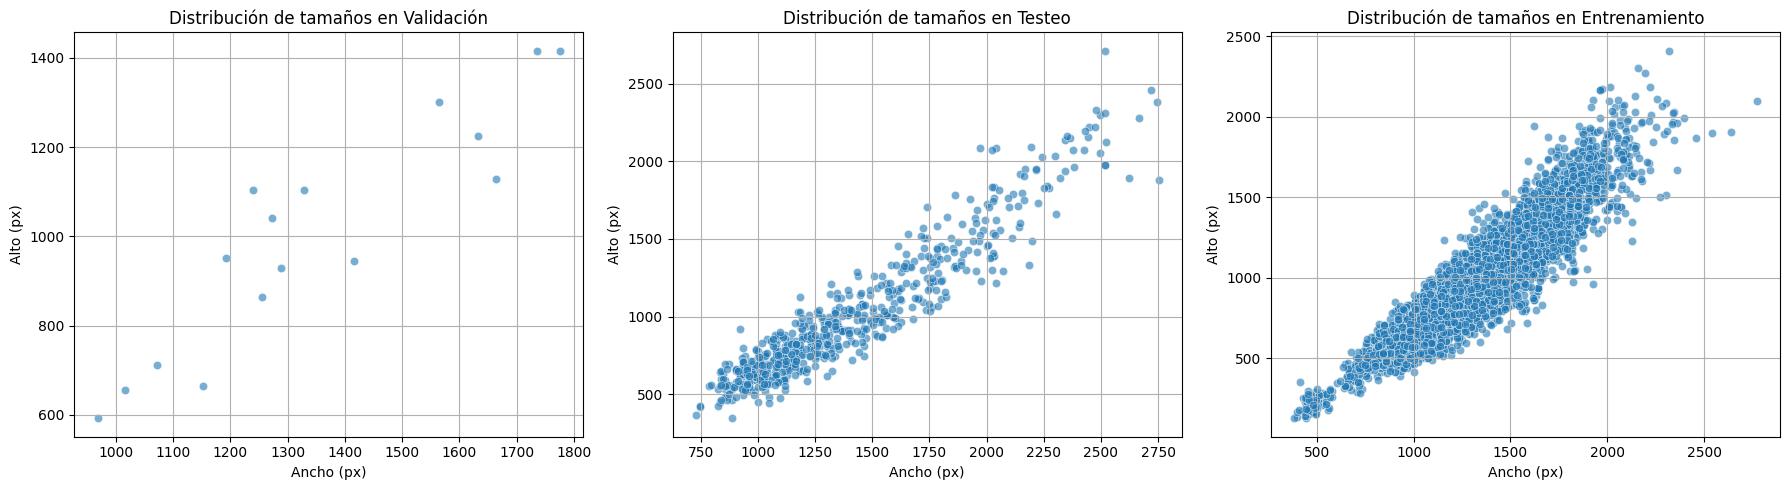

In [31]:
def graficar_tamanos(tamanos, titulo, ax):
    df = pd.DataFrame(tamanos, columns = ["Ancho", "Alto"])
    sns.scatterplot(data = df, x = "Ancho", y = "Alto", alpha = 0.6, ax = ax)
    ax.set_title(titulo)
    ax.set_xlabel("Ancho (px)")
    ax.set_ylabel("Alto (px)")
    ax.grid(True)

# Aplicar función 'graficar_tamanos'
fig, axs = plt.subplots(1, 3, figsize = (18, 5))  # 1 fila, 3 columnas
graficar_tamanos(tm_vl, "Distribución de tamaños en Validación", axs[0])
graficar_tamanos(tm_ts, "Distribución de tamaños en Testeo", axs[1])
graficar_tamanos(tm_tr, "Distribución de tamaños en Entrenamiento", axs[2])
plt.tight_layout()
plt.show()

**Visualizar imágenes**

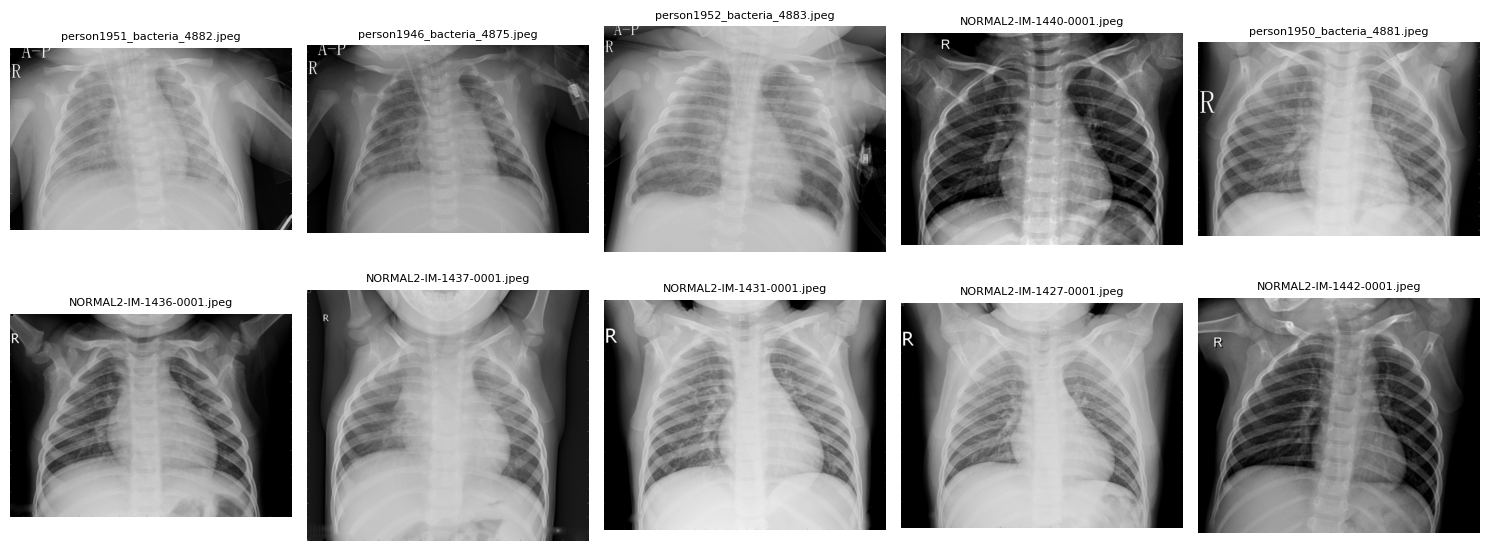

In [10]:
def mostrar_imagenes_aleatorias(ruta_base, cantidad=10):
    # Recolectar rutas de todas las imágenes
    rutas_imagenes = []
    for subcarpeta in os.listdir(ruta_base):
        ruta_subcarpeta = os.path.join(ruta_base, subcarpeta)
        if os.path.isdir(ruta_subcarpeta):
            for archivo in os.listdir(ruta_subcarpeta):
                rutas_imagenes.append(os.path.join(ruta_subcarpeta, archivo))

    seleccionadas = random.sample(rutas_imagenes, min(cantidad, len(rutas_imagenes)))

    plt.figure(figsize = (15, 6))
    for i, ruta in enumerate(seleccionadas):
        with Image.open(ruta) as img:
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap = 'gray')
            plt.title(os.path.basename(ruta), fontsize=8)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Aplicar la función
mostrar_imagenes_aleatorias(img_vali)

## **Procesamiento de imágenes**

### **Redimensionamiento**

In [11]:
# Parámetros de entrada
tamaño_imagen = (224, 224)
batch_size = 32

# Cargar datasets con redimensionamiento automático
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_train, # Entrenamiento
    image_size = tamaño_imagen,  # Redimensiona automáticamente
    batch_size = batch_size,
    label_mode = 'categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_vali, # Validación
    image_size = tamaño_imagen,
    batch_size = batch_size,
    label_mode = 'categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_test, # Testeo
    image_size=tamaño_imagen,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 5144 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


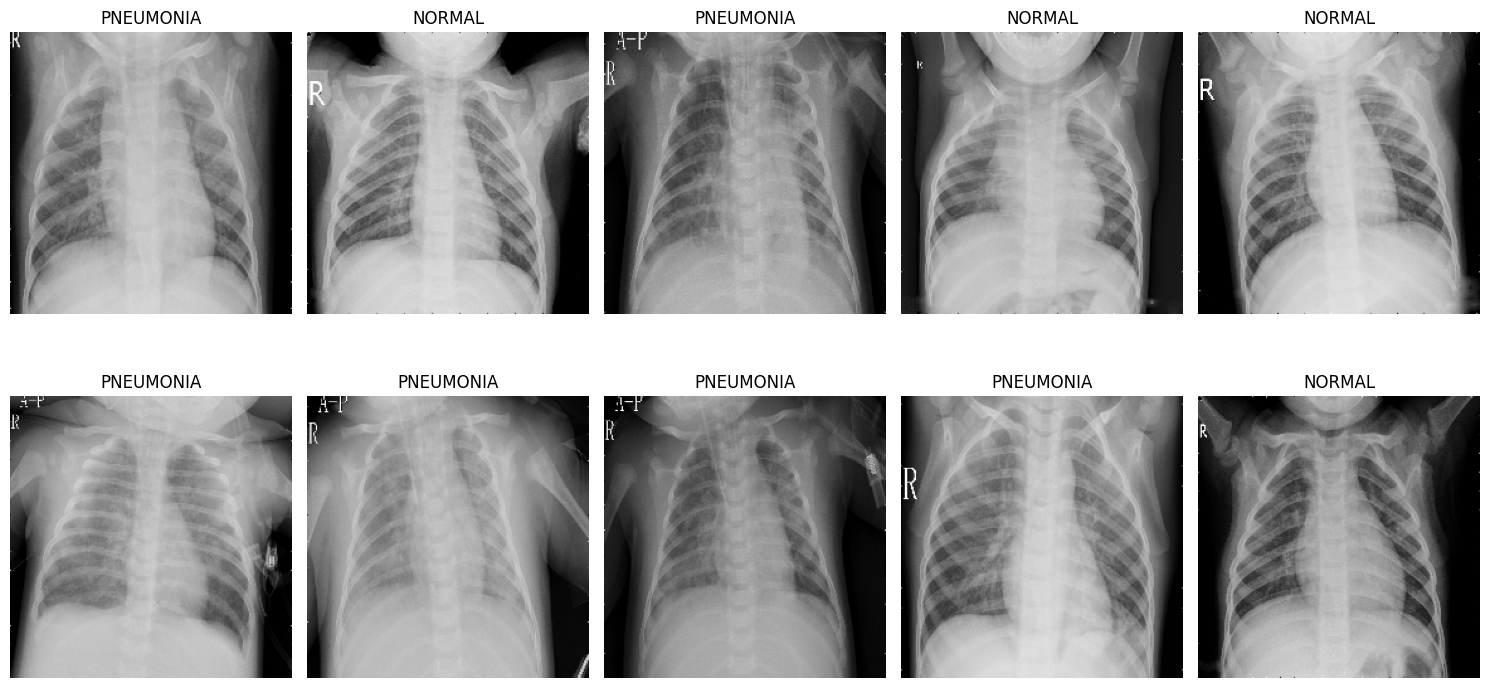

In [12]:
# Visualización de imágenes con sus etiquetas
class_names = val_ds.class_names  # ['NORMAL', 'PNEUMONIA']

for images, labels in val_ds.take(1):
    plt.figure(figsize = (15, 8))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i].numpy())
        plt.title(class_names[class_index])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### **Redimensión de forma local (Opcional)**

In [13]:
# def redimensionar_imagenes(ruta_origen, ruta_destino, nuevo_tamano = (224, 224)):
#     if not os.path.exists(ruta_destino):
#         os.makedirs(ruta_destino)

#     for clase in os.listdir(ruta_origen):  # NORMAL, PNEUMONIA
#         ruta_clase_origen = os.path.join(ruta_origen, clase)
#         ruta_clase_destino = os.path.join(ruta_destino, clase)

#         if not os.path.exists(ruta_clase_destino):
#             os.makedirs(ruta_clase_destino)

#         for archivo in os.listdir(ruta_clase_origen):
#             ruta_img_origen = os.path.join(ruta_clase_origen, archivo)
#             ruta_img_destino = os.path.join(ruta_clase_destino, archivo)

#             try:
#                 with Image.open(ruta_img_origen) as img:
#                     img_redimensionada = img.resize(nuevo_tamano)
#                     img_redimensionada.save(ruta_img_destino)
#             except Exception as e:
#                 print(f"Error con {ruta_img_origen}: {e}")

# # Directorios destino
# ruta_base = "/content/drive/MyDrive/Capstone/data"
# train_out = os.path.join(ruta_base, "train_redim")
# test_out = os.path.join(ruta_base, "test_redim")
# val_out = os.path.join(ruta_base, "val_redim")

# # Redimensionar
# redimensionar_imagenes(train, train_out)
# redimensionar_imagenes(test, test_out)
# redimensionar_imagenes(val, val_out)

### **Segmentación**

In [14]:
# En esta sección, se implementará la segmentación, antes de normalizar.

### **Normalización**

In [15]:
normalizar = lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)

train_ds = train_ds.map(normalizar)
val_ds = val_ds.map(normalizar)
test_ds = test_ds.map(normalizar)

## **Aplicación de clusterización para diferenciar la neumonía viral y bacteriana**

### ***Flatten* o extracción de características**

In [16]:
# Extraer datos del dataset completo
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []
    for batch in dataset:
        images, labels = batch
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    images_np = np.concatenate(images_list, axis=0)
    labels_np = np.concatenate(labels_list, axis=0)
    return images_np, labels_np

# Convertir los datos a vector
X_train, y_train = dataset_to_numpy(train_ds)

# Identificar índice de la clase "PNEUMONIA"
print("Clases:", class_names)  # ['NORMAL', 'PNEUMONIA']
indice_pneumonia = class_names.index('PNEUMONIA')

Clases: ['NORMAL', 'PNEUMONIA']
Cantidad de imágenes con neumonía: 3875
Forma original: (224, 224, 3)
Forma aplanada: (150528,)


In [ ]:
# Filtrar solo las imágenes con PNEUMONIA
mascara_pneumonia = np.argmax(y_train, axis=1) == indice_pneumonia
X_pneumonia = X_train[mascara_pneumonia]

print("Cantidad de imágenes con neumonía:", X_pneumonia.shape[0])

In [ ]:
# Flatten
X_pneumonia_flat = X_pneumonia.reshape(X_pneumonia.shape[0], -1)

print("Forma original:", X_pneumonia[0].shape)
print("Forma aplanada:", X_pneumonia_flat[0].shape)

### **Reducción de dimensionalidad**

In [24]:
# Reducir a n dimensiones
pca = PCA(n_components = 100, random_state = 42)
X_pneumonia_pca = pca.fit_transform(X_pneumonia_flat)

print("Nueva forma tras PCA:", X_pneumonia_pca.shape)

Nueva forma tras PCA: (3875, 100)


In [25]:
# Dos clústeres para los tipos de neumonía: viral y bacteriana)
kmeans = KMeans(n_clusters = 2, random_state = 42)
clusters = kmeans.fit_predict(X_pneumonia_pca)

### **Visualizar imágenes por clústeres**

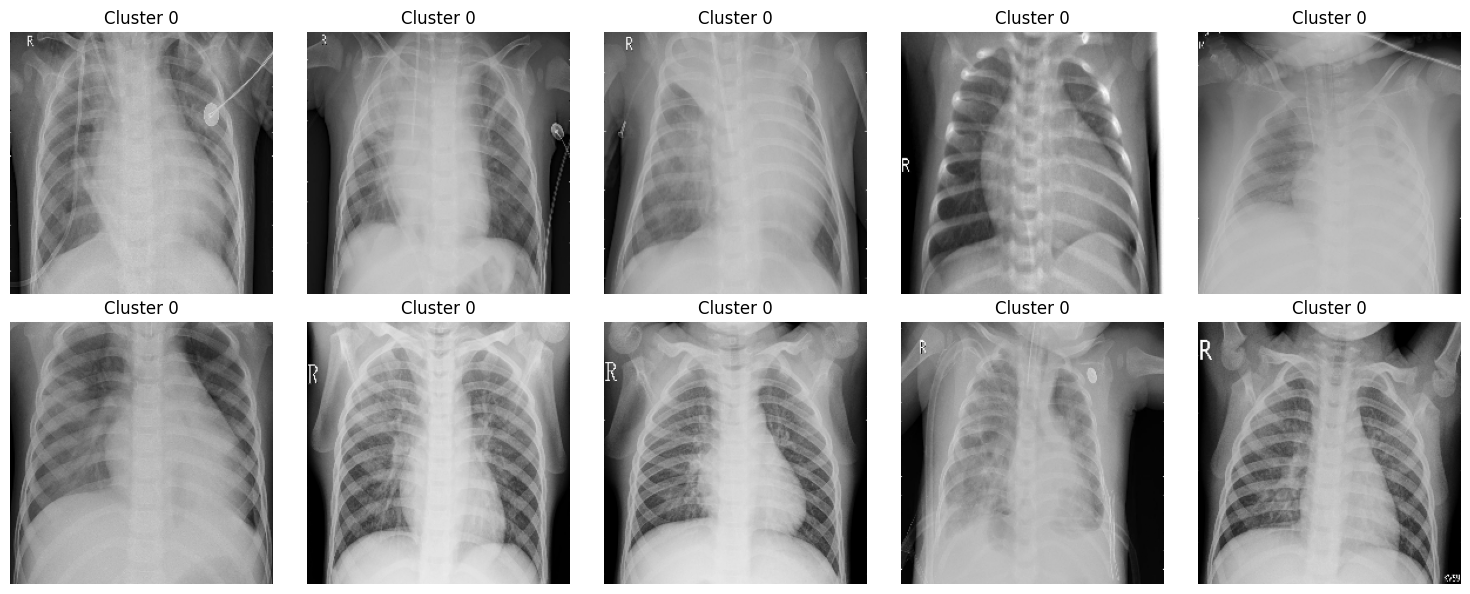

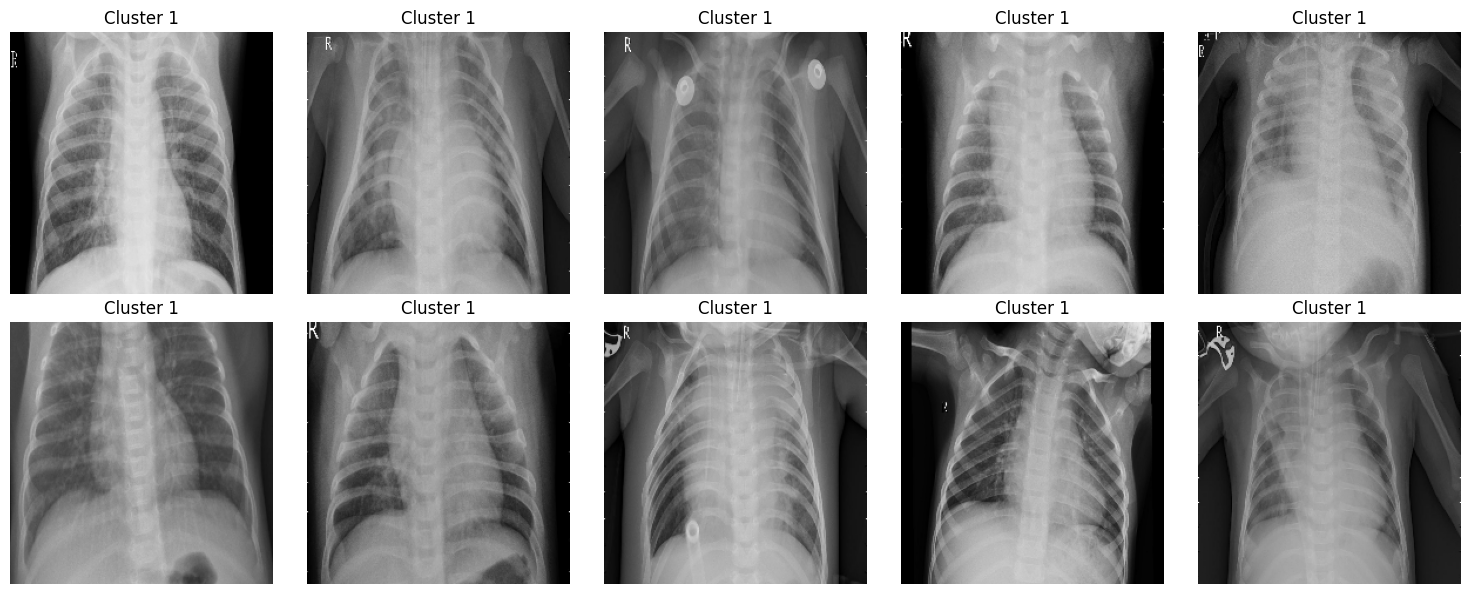

In [26]:
def mostrar_imagenes_por_cluster(imagenes, cluster_labels, cluster_id, cantidad = 10):
    indices = np.where(cluster_labels == cluster_id)[0]
    seleccionadas = np.random.choice(indices, min(cantidad, len(indices)), replace = False)

    plt.figure(figsize = (15, 6))
    for i, idx in enumerate(seleccionadas):
        plt.subplot(2, 5, i + 1)
        plt.imshow(imagenes[idx])
        plt.title(f"Cluster {cluster_id}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Mostrar imágenes del cluster 0 y 1
mostrar_imagenes_por_cluster(X_pneumonia, clusters, cluster_id = 0)
mostrar_imagenes_por_cluster(X_pneumonia, clusters, cluster_id = 1)

**Visualizar clústeres por TSNE**

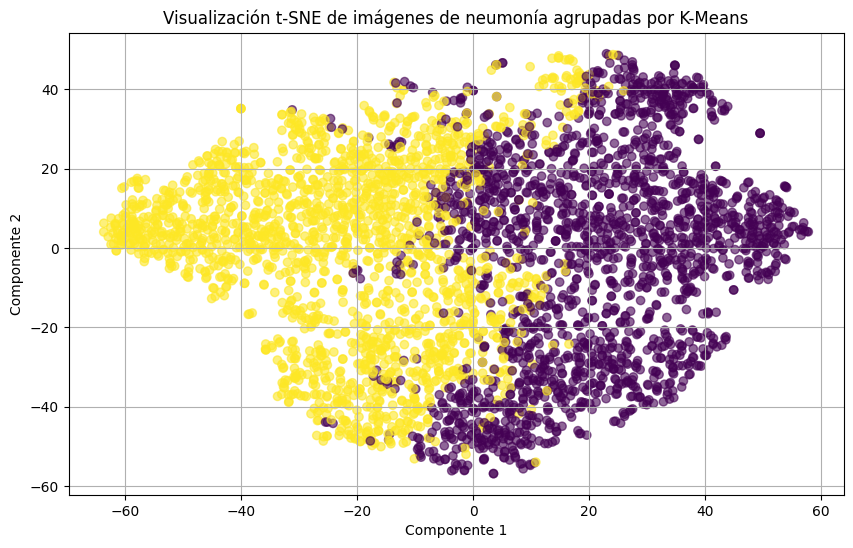

In [27]:
tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30)
X_pneumonia_2D = tsne.fit_transform(X_pneumonia_pca)

plt.figure(figsize = (10, 6))
plt.scatter(X_pneumonia_2D[:, 0], X_pneumonia_2D[:, 1], c = clusters, cmap='viridis', alpha = 0.6)
plt.title("Visualización t-SNE de imágenes de neumonía agrupadas por K-Means")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

### **Coeficiente de Siluetta**

In [28]:
# Usar los datos reducidos (PCA) para calcular la silueta
score_silueta = silhouette_score(X_pneumonia_pca, clusters)
print(f"Coeficiente de silueta: {score_silueta:.4f}")

Coeficiente de silueta: 0.1752
